In [1]:
import nltk  ##pip install nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\675399\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\675399\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay,roc_auc_score)

Matplotlib is building the font cache; this may take a moment.


In [3]:
from keras.preprocessing import sequence,text #pip install keras, pip install tensorflow, pip install scipy#
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Embedding,Conv1D,Flatten,MaxPooling1D,LSTM,SpatialDropout1D,Bidirectional

In [4]:
## config parameters for cnn 
vocab_size = 1000  ##most used words length
maxlen = 280  ##number of characters to consider per review
batch_size = 128
embedding_dims = 128  ##too little will cause underfitting, too large will cause overfitting
filters = 4  ##number of output channels the network has
kernel_size = 3
hidden_dims = 70
epochs = 10

In [5]:
#load the data
df = pd.read_csv('gpt.csv')

In [6]:
df

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...,...
219289,219289,Other Software Projects Are Now Trying to Repl...,bad
219290,219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,219291,chatgpt is being disassembled until it can onl...,bad
219292,219292,2023 predictions by #chatGPT. Nothing really s...,bad


In [7]:
#feature selection
new_df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
new_df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


# Preprocessing

In [9]:
def data_processing(text):
    #change to lowercase
    text = text.lower()
    #remove links using http(s)
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    ##remove \n
    text = text.replace("\\n", " ")
    #remove special characters
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    return " ".join(text_tokens).strip()

In [10]:
review = new_df['tweets'].apply(data_processing)

In [11]:
review[19]

'i asked chatgpt a new ai system that is optimized for dialogue to teach me seo in a minute the result'

In [12]:

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [13]:
# new_text = text.apply(lambda x: stemming(x))
new_text = review.apply(stemming)

In [14]:
new_text[19]

'i asked chatgpt a new ai system that is optimized for dialogue to teach me seo in a minute the result'

In [15]:
new_df['cleaned_tweets'] = new_text

In [16]:
new_df

,tweets,labels,cleaned_tweets
0,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimizing language models for dialogu...
1,"Try talking with ChatGPT, our new AI system wh...",good,try talking with chatgpt our new ai system whi...
2,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimizing language models for dialogu...
3,"THRILLED to share that ChatGPT, our new model ...",good,thrilled to share that chatgpt our new model o...
4,"As of 2 minutes ago, @OpenAI released their ne...",bad,as of 2 minutes ago openai released their new ...
...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad,other software projects are now trying to repl...
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good,i asked chatgpt to write a nye joke for seos a...
219291,chatgpt is being disassembled until it can onl...,bad,chatgpt is being disassembled until it can onl...
219292,2023 predictions by #chatGPT. Nothing really s...,bad,2023 predictions by chatgpt nothing really spe...


In [17]:
data = new_df[['cleaned_tweets','labels']]

In [18]:
data

,cleaned_tweets,labels
0,chatgpt optimizing language models for dialogu...,neutral
1,try talking with chatgpt our new ai system whi...,good
2,chatgpt optimizing language models for dialogu...,neutral
3,thrilled to share that chatgpt our new model o...,good
4,as of 2 minutes ago openai released their new ...,bad
...,...,...
219289,other software projects are now trying to repl...,bad
219290,i asked chatgpt to write a nye joke for seos a...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by chatgpt nothing really spe...,bad


In [19]:
pd.DataFrame(data['labels'].value_counts())

,count
labels,
bad,107796
good,56011
neutral,55487


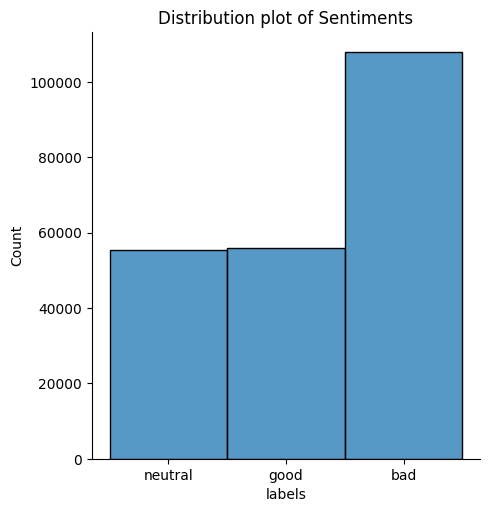

In [20]:
sns.displot(data=data, x='labels',multiple = 'stack').set(title='Distribution plot of Sentiments')

# Modelling

In [21]:
# X = data.drop('labels', axis = 1)
# y = data['labels']

In [22]:
##split the data
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_tweets'], data['labels'], test_size=0.3, random_state=20)

In [23]:
print("Size of x_train:", (X_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (X_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (153505,)
Size of y_train: (153505,)
Size of x_test: (65789,)
Size of y_test: (65789,)


In [24]:
vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words='english',
)

x_train = vec.fit_transform(X_train)
x_test = vec.transform(X_test)

In [25]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (153505, 2029158)
Size of y_train: (153505,)
Size of x_test: (65789, 2029158)
Size of y_test: (65789,)


In [26]:
print(x_train)

  (0, 1797599)	1
  (0, 1323943)	1
  (0, 167867)	1
  (0, 62985)	1
  (0, 295408)	1
  (0, 839085)	1
  (0, 1913049)	1
  (0, 1251263)	1
  (0, 1971000)	1
  (0, 427949)	1
  (0, 1800884)	1
  (0, 1324063)	1
  (0, 167880)	1
  (0, 67092)	1
  (0, 331353)	1
  (0, 842032)	1
  (0, 1914083)	1
  (0, 1252046)	1
  (0, 1971714)	1
  (0, 1800885)	1
  (0, 1324064)	1
  (0, 167882)	1
  (0, 67443)	1
  (0, 331613)	1
  (0, 842041)	1
  :	:
  (153504, 658861)	1
  (153504, 344766)	1
  (153504, 463991)	1
  (153504, 1124016)	1
  (153504, 344769)	1
  (153504, 219420)	1
  (153504, 1456635)	1
  (153504, 483763)	1
  (153504, 1018751)	1
  (153504, 101339)	1
  (153504, 784630)	1
  (153504, 1353272)	1
  (153504, 464416)	1
  (153504, 608798)	1
  (153504, 659090)	1
  (153504, 1124018)	1
  (153504, 101340)	1
  (153504, 784631)	1
  (153504, 1353273)	1
  (153504, 463992)	1
  (153504, 483765)	1
  (153504, 464417)	1
  (153504, 608799)	1
  (153504, 1456636)	1
  (153504, 659091)	1


In [27]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("test accuracy: {:.2f}%".format(logreg_acc*100))

C:\Users\675399\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test accuracy: 83.93%


In [28]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 81.27%


C:\Users\675399\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb_preds = nb.predict(x_test)
nb_acc = accuracy_score(nb_preds, y_test)
print("test accuracy: {:.2f}%".format(nb_acc*100))
# print(classification_report(y_test, preds))

test accuracy: 72.85%


Modelling using CNN

In [30]:
from tensorflow.keras.utils import to_categorical

#transfer labels to integers
le = LabelEncoder()
labels = le.fit_transform(data['labels'])
labels = to_categorical(labels)

In [31]:
from keras.utils import pad_sequences

##prepare input by converting the text to acceptable integers for cnn
tokenizer =  text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['cleaned_tweets'])
sequences = tokenizer.texts_to_sequences(data['cleaned_tweets'])
word_index = tokenizer.word_index
maxlen = max([len(seq) for seq in sequences])
## padd the numbers with zero to meet the maxlen
x = pad_sequences(sequences, maxlen=maxlen)

##split data
X1_train, X1_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42)
X,y=X1_train,y_train
X1_train, X1_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [32]:
labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [33]:
print("Size of x_train:", (X1_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (X1_test.shape))
print("Size of y_test:", (y_test.shape))
print("Size of x_val:", (X1_val.shape))
print("Size of y_val:", (y_val.shape))

Size of x_train: (140348, 59)
Size of y_train: (140348, 3)
Size of x_test: (43859, 59)
Size of y_test: (43859, 3)
Size of x_val: (35087, 59)
Size of y_val: (35087, 3)


In [34]:
embeddings_index = {}
with open('C:/Users/Public/Downloads/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [35]:
num_labels = len(le.classes_)
word_index = tokenizer.word_index

model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='softmax'))


In [36]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # you can change the patience 


# Train the model
history = model.fit(X1_train, y_train, validation_data=(X1_val,y_val), epochs=20, batch_size=32) #without earlystopping

# history = model.fit(X_train, y_train, validation_data=(X1_val,y_val), epochs=20, batch_size=32, callbacks=[early_stopping]) # you can increase the number of epochs 


Epoch 1/20
4386/4386 [==============================] - 267s 60ms/step - loss: 0.7691 - accuracy: 0.6703 - val_loss: 0.6675 - val_accuracy: 0.7299
Epoch 2/20
4386/4386 [==============================] - 260s 59ms/step - loss: 0.6615 - accuracy: 0.7372 - val_loss: 0.6254 - val_accuracy: 0.7602
Epoch 3/20
4386/4386 [==============================] - 262s 60ms/step - loss: 0.6235 - accuracy: 0.7586 - val_loss: 0.6013 - val_accuracy: 0.7723
Epoch 4/20
4386/4386 [==============================] - 261s 60ms/step - loss: 0.6024 - accuracy: 0.7697 - val_loss: 0.5929 - val_accuracy: 0.7750
Epoch 5/20
4386/4386 [==============================] - 268s 61ms/step - loss: 0.5867 - accuracy: 0.7762 - val_loss: 0.5864 - val_accuracy: 0.7801
Epoch 6/20
4386/4386 [==============================] - 266s 61ms/step - loss: 0.5765 - accuracy: 0.7799 - val_loss: 0.5830 - val_accuracy: 0.7831
Epoch 7/20
4386/4386 [==============================] - 266s 61ms/step - loss: 0.5674 - accuracy: 0.7841 - val_loss: 0

In [38]:
#To save the model
model.save('sentiment_analysis_model.h5')

In [39]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X1_test, y_test)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")


1371/1371 [==============================] - 12s 9ms/step - loss: 0.5918 - accuracy: 0.7872
Accuracy: 78.72%


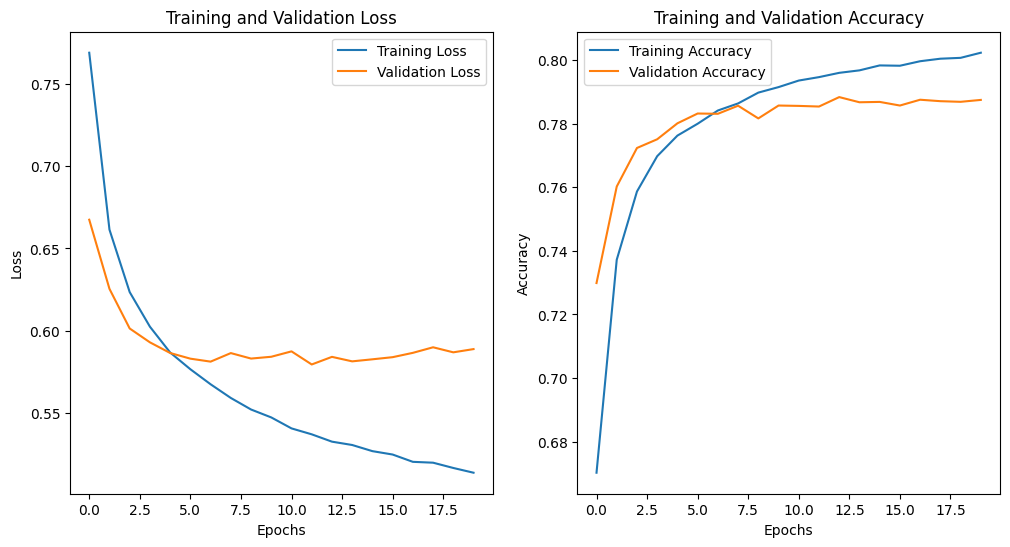

In [40]:
import matplotlib.pyplot as plt

# Get the training and test loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and test loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [41]:
#To load the model
from tensorflow.keras.models import load_model

loaded_model = load_model('sentiment_analysis_model.h5')



For hyperparameter tuning, we use GridSearchCV from sklearn and a custom KerasClassifier. First, create a function to build the model with hyperparameters as input arguments:

N.B: This is computationally expensive

In [42]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(embedding_dim=100, lstm_units=100, learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(lstm_units))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

Create a KerasClassifier using the create_model function, and set up the hyperparameter grid for tuning:

In [43]:
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

param_grid = {
    'learning_rate': [0.001, 0.01]
}
#   parameters that can be possibly tuned:  'lstm_units': [100, 150],   
#                       'learning_rate': [0.001, 0.01]  'embedding_dim': [50, 100]

C:\Users\675399\AppData\Local\Temp\ipykernel_15480\2966158193.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)


Now, create a GridSearchCV object with the desired settings and fit it to the data:

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
# grid_result = grid.fit(X1_train, y_train, validation_data=(X1_test, y_test), callbacks=[early_stopping])
grid_result = grid.fit(X1_train, y_train, validation_data=(X1_val, y_val))

After fitting the grid search, you can access the best hyperparameters and the best score:

In [ ]:
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Finally, save the best model using grid_result.best_estimator_.model:

In [ ]:
best_model = grid_result.best_estimator_.model
best_model.save('best_sentiment_analysis_model.h5')
